In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import re

import os
if not os.path.exists('figures'):
    os.makedirs('figures')

In [2]:
combined = pd.read_csv('../data/hcr_quant/counts.csv', index_col=0)
combined['treatment'] = combined.apply(lambda x: x.embryo.split('_')[0], axis=1)
# drop chopped or poorly imaged embryos
to_drop = [
    "MK886/MK_1_7/groupA/18_MK_1_7_emb1001.nd2",
    "MK886/MK_1_7/groupA/18_MK_1_7_emb1002.nd2",
    "MK886/MK_1_7/replicate2/18hpf_MK1_7uM_emb1003.nd2",
    "MK886/MK_1_7/replicate2/18hpf_MK1_7uM_emb1004.nd2",
    "MK886/MK_2_0/replicate2/18hpf_MK2uM_emb1002.nd2",
    "MK886/MK_2_0/groupB/18_MK_2_emb1001.nd2",
    "MK886/MK_2_0/replicate2/18hpf_MK2uM_emb1001.nd2"
]
to_drop = [x.replace('_', '-').replace('/', '_').replace('.nd2', '') for x in to_drop]
combined = combined.query('embryo not in @to_drop')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['svg.fonttype'] = 'path'
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
combined[['sm50_scaled', 'pks2_scaled']] = combined.groupby('embryo')[['sm50_intensity', 'pks2_intensity']].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
pks2_up = np.percentile(combined.pks2_scaled, 75)
sm50_down = np.percentile(combined.sm50_scaled, 25)
combined['pks2_plus'] = combined.apply(lambda x: x.sm50_scaled < sm50_down and x.pks2_scaled > pks2_up, axis=1)

pks2_down = np.percentile(combined.pks2_scaled, 25)
sm50_up = np.percentile(combined.sm50_scaled, 75)
combined['pks2_minus'] = combined.apply(lambda x: x.sm50_scaled > sm50_up and x.pks2_scaled < pks2_down, axis=1)

print(f"pks2 thresholds: ({pks2_down:0.2f}, {pks2_up:0.2f})\nsm50 threshold: ({sm50_down:0.2f}, {sm50_up:0.2f})")

pks2 thresholds: (0.14, 0.55)
sm50 threshold: (0.22, 0.66)


In [4]:
combined.groupby('treatment').agg(
    {
        'pks2_plus': 'sum',
        'pks2_minus': 'sum'
    })

,pks2_plus,pks2_minus
treatment,,
DMSO,3,56
MK886,62,38


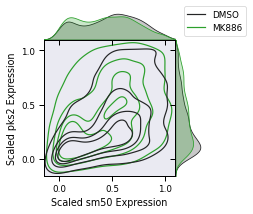

In [5]:
import matplotlib as mpl
sns.set_context("paper")
g = sns.jointplot(
    data=combined, 
    x='sm50_scaled',
    y='pks2_scaled',
    hue='treatment',
    kind='kde',
    # alpha_fil
    height=3,
    palette=[sns.color_palette()[2], '#242526'],
    levels=5,
    space=0,
    # shade=True,
    # alpha=0.5,
    xlim=(-0.15, 1.1),
    ylim=(-0.15, 1.1),
    marginal_kws={'common_norm': False, 'shade': True},
    )
g.ax_joint.set_xlabel("Scaled sm50 Expression")
g.ax_joint.set_ylabel("Scaled pks2 Expression")
h, l = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend_._visible=False
elements = [
    mpl.lines.Line2D([0], [0], color='#242526', label='DMSO'),
    mpl.lines.Line2D([0], [0], color=sns.color_palette()[2], label='MK886')]
g.fig.legend(handles=elements, bbox_to_anchor=(0.85, 1), loc=2)
g.ax_joint.set_facecolor("#EAEAF2")
g.ax_joint.set_yticks([0, 0.5, 1])
g.ax_joint.set_xticks([0, 0.5, 1])
# g.ax_marg_x.axvline(x=sm50_thresh, lw=2, ls='--', c='black')
# g.ax_marg_y.axhline(y=pks2_thresh, lw=2, ls='--', c='black')
plt.savefig('figures/distributions.svg', bbox_inches='tight', dpi=200)

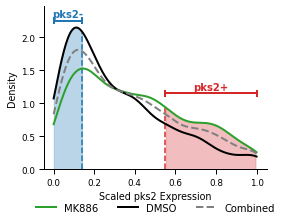

In [6]:
def dist_by_treatment_plot(data, column, l_threshold, u_threshold, clip=None):
    ax = sns.kdeplot(
        data.query('treatment == "MK886"')[column],
        color=sns.color_palette()[2],
        clip=clip, 
        label='MK886',
        lw=2
    )
    ax = sns.kdeplot(
        data.query('treatment == "DMSO"')[column], 
        color='black',
        clip=clip, 
        label='DMSO',
        lw=2
    )
    ax = sns.kdeplot(
        data[column],
        color='gray',
        clip=clip,
        label="Combined",
        lw=2,
        ls='--'
    )
    mk = ax.lines[0].get_xydata()
    dmso = ax.lines[1].get_xydata()

    def get_threshold_idx(xy_data, threshold):
        idx = 0
        while xy_data[idx, 0] < threshold and xy_data[idx, 0] < 1:
            idx += 1
        return idx

    l_idx = get_threshold_idx(mk, l_threshold)
    zero_idx = get_threshold_idx(mk, 0)
    u_idx = get_threshold_idx(mk, u_threshold)
    one_idx = get_threshold_idx(mk, 1)

    min_y = min(mk[:, 1].min(), dmso[:, 1].min())
    max_y = max(mk[:, 1].max(), dmso[:, 1].max())
    ax.set_ylim(min_y - min_y * 0.1, max_y + max_y * 0.15)
    # ax.set_xlim(-0.075, 1.025)
    # ax.set_xlim(0, 1)

    def get_max_curve(xy_data1, xy_data2, row_slc):
        return np.stack([xy_data1[row_slc, 1], xy_data2[row_slc, 1]]).max(axis=0)


    upper_y1 = get_max_curve(mk, dmso, slice(zero_idx, l_idx))
    ax.fill_between(mk[zero_idx:l_idx, 0], upper_y1, color=sns.color_palette()[0], alpha=0.3)

    upper_y2 = get_max_curve(mk, dmso, slice(u_idx, one_idx))
    ax.fill_between(mk[u_idx:one_idx, 0], upper_y2, color=sns.color_palette()[3], alpha=0.3)
    # ax.fill_between(mk[:l_idx, 0], lower_y, color=sns.color_palette()[0], alpha=0.3)
    ax.vlines(
        x=l_threshold,
        ymin=0,
        ymax=max(mk[l_idx, 1], dmso[l_idx, 1]),
        lw=1.5,
        ls='--',
        color=sns.color_palette()[0])
    ax.vlines(
        x=u_threshold,
        ymin=0,
        ymax=upper_y2[0],
        lw=1.5,
        ls='--',
        color=sns.color_palette()[3])
    plt.legend(fontsize=10, fancybox=False, frameon=False, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
    limits = ax.get_ylim()
    ax.set_ylim(0, limits[1])
    sns.despine()
    return ax


def annotate_up_down(anno_dict, ax):
    for text, params in anno_dict.items():
        y = params['y']
        delta = params['delta']
        ax.hlines(
            y=y,
            xmin=params["xmin"],
            xmax=params["xmax"],
            lw=2,
            color=params['color']
        )
        ax.vlines(
            x=params['xmin'],
            ymin=y - delta,
            ymax=y + delta,
            lw=2,
            color=params['color']
        )
        ax.vlines(
            x=params['xmax'],
            ymin=y - delta,
            ymax=y + delta,
            lw=2,
            color=params['color']
        )
        ax.annotate(
            text=text,
            xy=((params['xmin'] + params['xmax'])/ 2, params['texty']),
            horizontalalignment='center',
            color=params['color'],
            fontsize=10,
            fontweight='bold'
        )


pks2_dict = {
    'pks2+': {'y': 1.15, "xmin": pks2_up, "xmax": 1, "delta": 0.0525, "texty": 1.2, 'color': sns.color_palette()[3]},
    'pks2-': {'y': 2.25, "xmin": 0, "xmax": pks2_down, "delta": 0.0525, "texty": 2.3, 'color': sns.color_palette()[0]}
}
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(4, 3))
ax = dist_by_treatment_plot(combined, 'pks2_scaled', pks2_down, pks2_up, clip=[0, 1])
annotate_up_down(pks2_dict, ax)
ax.set_xlabel("Scaled pks2 Expression")
plt.savefig('figures/pks2_distribution.svg', bbox_inches='tight', dpi=200)

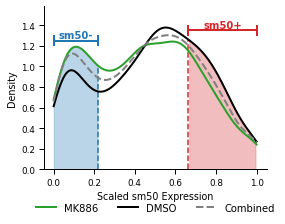

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))
sm50_dict = {
    'sm50+': {'y': 1.35, "xmin": sm50_up, "xmax": 1, "delta": 0.0525, "texty": 1.375, 'color': sns.color_palette()[3]},
    'sm50-': {'y': 1.25, "xmin": 0, "xmax": sm50_down, "delta": 0.0525, "texty": 1.275, 'color': sns.color_palette()[0]}
}
ax = dist_by_treatment_plot(combined, 'sm50_scaled', sm50_down, sm50_up, clip=[0, 1])
# ax.set_ylim(0, 1.6)
annotate_up_down(sm50_dict, ax)
ax.set_xlabel("Scaled sm50 Expression")
plt.savefig('figures/sm50_distribution.svg', bbox_inches='tight', dpi=200)

In [31]:



rep_search = re.compile('replicate[0-9]', re.IGNORECASE)
def parse_fert(x):
    match = rep_search.search(x)
    if match is not None:
        return match.group(0).lower()
    return 'replicate1'

    
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)


    References
    ----------
    Modified from:
    https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
    """

    if type(data) is str:
        text = data
    else:
        if data < 0.05 and data > 0.01:
            text = '$p<0.05$'
        elif data < 0.01 and data > 0:
            t = -1
            while data < 10**(t - 1):
                t = t - 1
            text = '$p<10^{%d}$' % t
        elif data == 0:
            text = '*'
        else:
            text = 'n.s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom', fontweight='bold')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)


def swarm_and_mean_plot(df, x, y, point_plot_kwargs={}, boxplot_kwargs={}, swarmplot_kwargs={}, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax = sns.pointplot(
        data=df,
        x=x,
        y=y,
        join=False,
        ci=95,
        capsize=.3,
        markers='_',
        edgecolor=None,
        zorder=2,
        color='#242526',
        ax=ax,
        **point_plot_kwargs
    )
    ax = sns.boxplot(
        data=df,
        x=x,
        y=y,
        showmeans=True,
        meanline=True,
        meanprops={'color': '#242526', 'ls': '-', 'lw': 3},
        medianprops={'visible': False, 'lw': 3},
        whiskerprops={'visible': False, 'lw': 3},
        zorder=2,
        showfliers=False,
        showbox=False,
        showcaps=False,
        ax=ax,
        **boxplot_kwargs
    )
    ax = sns.swarmplot(
        data=df,
        x=x, 
        y=y,
        ax=ax,
        zorder=0,
        **swarmplot_kwargs
    )
    sns.despine()


def analyze_proportions(df, prop_col):
    df['non_phenotypic'] = df['total_cells'] - df[prop_col]
    model = smf.glm(
        formula=f"{prop_col} + non_phenotypic ~ C(treatment) + C(fert)",
        data=embryo_df, family=sm.families.Binomial()
    ).fit()
    p = model.pvalues['C(treatment)[T.MK886]']
    return model, p 


In [32]:
embryo_df = combined.groupby('embryo').agg(
    pks2_plus=('pks2_plus', 'sum'),
    pks2_minus=('pks2_minus', 'sum'),
    total_cells=('pks2_plus', 'size')
)

embryo_df['treatment'] = embryo_df.apply(lambda x: x.name.split('_')[0], axis=1)
embryo_df['pks2_plus_proportion'] = embryo_df['pks2_plus'] / embryo_df['total_cells'] * 100
embryo_df['pks2_minus_proportion'] = embryo_df['pks2_minus'] / embryo_df['total_cells'] * 100
embryo_df['fert'] = embryo_df.apply(lambda x: parse_fert(x.name), axis=1)

print(embryo_df.groupby('treatment').size())
embryo_df.head()

treatment
DMSO     26
MK886    37
dtype: int64


,pks2_plus,pks2_minus,total_cells,treatment,pks2_plus_proportion,pks2_minus_proportion,fert
embryo,,,,,,,
DMSO_Replicate2_18hpf-DMSO-R2-emb1,0,3,58,DMSO,0.000000,5.172414,replicate2
DMSO_Replicate2_18hpf-DMSO-R2-emb2,0,6,64,DMSO,0.000000,9.375000,replicate2
DMSO_Replicate2_18hpf-DMSO-emb1001,0,3,57,DMSO,0.000000,5.263158,replicate2
DMSO_Replicate2_18hpf-DMSO-emb1002,0,3,55,DMSO,0.000000,5.454545,replicate2
DMSO_Replicate2_18hpf-DMSO-emb1003,2,1,61,DMSO,3.278689,1.639344,replicate2


/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgecolors ([(0.1411764705882353, 0.1450980392156863, 0.14901960784313725), (0.1411764705882353, 0.1450980392156863, 0.14901960784313725)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 73.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


treatment
DMSO     0.187153
MK886    2.714329
Name: pks2_plus_proportion, dtype: float64


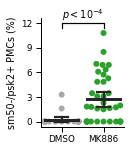

In [33]:
if not os.path.exists('tables'):
    os.makedirs('tables')
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(1.5, 2))
swarmplot_kwargs={'s': 7, 'palette': ['darkgray', sns.color_palette()[2]]}
swarm_and_mean_plot(
    df=embryo_df,
    x='treatment',
    y='pks2_plus_proportion',
    ax=ax,
    swarmplot_kwargs={'s': 6, 'palette': ['darkgray', sns.color_palette()[2]]}
)

ax.set_xlabel('')
ax.set_ylabel('sm50-/psk2+ PMCs (%)')
ax.set_yticks(range(0, 15, 3))
pks2_plus_model, p = analyze_proportions(embryo_df, 'pks2_plus')
barplot_annotate_brackets(0, 1, p, center=np.arange(2), height=embryo_df.groupby('treatment')['pks2_plus_proportion'].max().values)
plt.savefig('figures/pks_plus_percent_cells.svg')
pks2_plus_model.summary2().tables[1].to_csv('tables/pks2_plus_model_summary.csv')
print(embryo_df.groupby('treatment')['pks2_plus_proportion'].mean())

In [34]:
pks2_plus_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Generalized Linear Model Regression Results                        
===========================================================================================
Dep. Variable:     ['pks2_plus', 'non_phenotypic']   No. Observations:                   63
Model:                                         GLM   Df Residuals:                       59
Model Family:                             Binomial   Df Model:                            3
Link Function:                               logit   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -73.004
Date:                             Tue, 03 May 2022   Deviance:                       79.947
Time:                                     15:19:52   Pearson chi2:                     138.
No. Iterations:                                  9                                         
Covariance Type:                         nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -6.2009      0.606    -10.238      0.000      -7.388      -5.014
C(treatment)[T.MK886]     2.6031      0.593      4.390      0.000       1.441       3.765
C(fert)[T.replicate2]    -0.9703      0.497     -1.952      0.051      -1.944       0.004
C(fert)[T.replicate3]     0.4173      0.270      1.547      0.122      -0.111       0.946
=========================================================================================
"""

treatment
DMSO     3.586045
MK886    1.906644
Name: pks2_minus_proportion, dtype: float64


/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgecolors ([(0.1411764705882353, 0.1450980392156863, 0.14901960784313725), (0.1411764705882353, 0.1450980392156863, 0.14901960784313725)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dakota/anaconda3/envs/single-cell/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


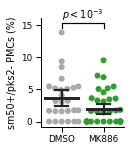

In [35]:
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(1.5, 2))
swarm_and_mean_plot(
    df=embryo_df,
    x='treatment',
    y='pks2_minus_proportion',
    ax=ax,
    swarmplot_kwargs={'s': 6, 'palette': ['darkgray', sns.color_palette()[2]]}
)

ax.set_xlabel('')
ax.set_ylabel('sm50+/pks2- PMCs (%)')
pks2_minus_model, p = analyze_proportions(embryo_df, 'pks2_minus')
barplot_annotate_brackets(0, 1, p, center=np.arange(2), height=embryo_df.groupby('treatment')['pks2_minus_proportion'].max().values)
plt.savefig('figures/pks_minus_percent_cells.svg')
pks2_minus_model.summary2().tables[1].to_csv('tables/pks2_minus_model_summary.csv')
print(embryo_df.groupby('treatment')['pks2_minus_proportion'].mean())


In [36]:
pks2_minus_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Generalized Linear Model Regression Results                         
============================================================================================
Dep. Variable:     ['pks2_minus', 'non_phenotypic']   No. Observations:                   63
Model:                                          GLM   Df Residuals:                       59
Model Family:                              Binomial   Df Model:                            3
Link Function:                                logit   Scale:                          1.0000
Method:                                        IRLS   Log-Likelihood:                -93.080
Date:                              Tue, 03 May 2022   Deviance:                       86.905
Time:                                      15:19:52   Pearson chi2:                     71.8
No. Iterations:                                   8                                         
Covariance Type:                          nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.8642      0.180    -15.931      0.000      -3.217      -2.512
C(treatment)[T.MK886]    -0.7134      0.217     -3.295      0.001      -1.138      -0.289
C(fert)[T.replicate2]    -0.1442      0.230     -0.627      0.530      -0.595       0.306
C(fert)[T.replicate3]    -1.6065      0.337     -4.769      0.000      -2.267      -0.946
=========================================================================================
"""

In [37]:
pks2_plus_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Generalized Linear Model Regression Results                        
===========================================================================================
Dep. Variable:     ['pks2_plus', 'non_phenotypic']   No. Observations:                   63
Model:                                         GLM   Df Residuals:                       59
Model Family:                             Binomial   Df Model:                            3
Link Function:                               logit   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -73.004
Date:                             Tue, 03 May 2022   Deviance:                       79.947
Time:                                     15:19:52   Pearson chi2:                     138.
No. Iterations:                                  9                                         
Covariance Type:                         nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -6.2009      0.606    -10.238      0.000      -7.388      -5.014
C(treatment)[T.MK886]     2.6031      0.593      4.390      0.000       1.441       3.765
C(fert)[T.replicate2]    -0.9703      0.497     -1.952      0.051      -1.944       0.004
C(fert)[T.replicate3]     0.4173      0.270      1.547      0.122      -0.111       0.946
=========================================================================================
"""